In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os
import urllib.request
import zipfile
import json
import nibabel as nib
import numpy as np

In [2]:
def load_data(jsonData, dataFolderPath, filterString='0001'):
    training_paths = []
    for i in range(len(jsonData['training_paired_images'])):
        tmproot, tmpext = os.path.splitext(jsonData['training_paired_images'][i]['moving'])
        root, ext = os.path.splitext(tmproot)
        splitRoot = root.split('_')
        if splitRoot[-1] == filterString:
            training_paths.append(jsonData['training_paired_images'][i])

    fixedData = []
    movingData = []
    for image in training_paths:
        fixedImg = nib.load(dataFolderPath + image['fixed'].removeprefix('.')).get_fdata()
        fixedData.append(fixedImg.astype(np.uint8))
        movingImg = nib.load(dataFolderPath + image['moving'].removeprefix('.')).get_fdata()
        movingImg_reshaped = movingImg.reshape(jsonData['tensorImageShape'][0]['0'][0],
                                               jsonData['tensorImageShape'][0]['0'][1], 3)
        movingData.append(movingImg_reshaped.astype(np.uint8))

    return np.array(fixedData), np.array(movingData)


def rgb_to_grayscale(image):
    # Extract RGB components
    red_channel = image[:, :, 0]  # Red channel
    green_channel = image[:, :, 1]  # Green channel
    blue_channel = image[:, :, 2]  # Blue channel

    # Convert to grayscale using the luminance formula
    grayscale_image = red_channel * 0.2989 + green_channel * 0.5870 + blue_channel * 0.1140

    return grayscale_image

In [3]:
with open('./data/COMULISSHGBF/COMULISSHGBF_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './data/COMULISSHGBF'
data_fixed, data_moved = load_data(data_json, dataFolder)

(np.float64(-0.5), np.float64(833.5), np.float64(833.5), np.float64(-0.5))

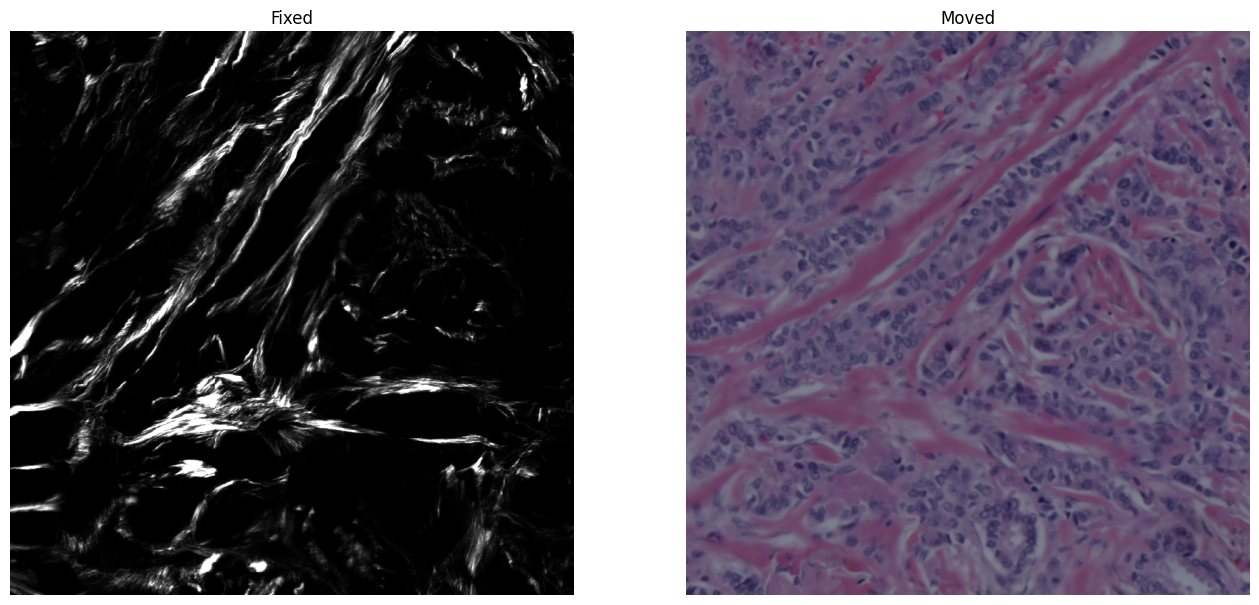

In [4]:
img = 6

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))
ax0.imshow(data_fixed[img], cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(data_moved[img])
ax1.set_title("Moved")
ax1.axis("off")

In [5]:
data_fixed[img].shape

(834, 834, 1)

In [6]:
data_moved[img].shape

(834, 834, 3)

In [7]:
gray_moving_image = rgb_to_grayscale(data_moved[img])

In [8]:
fixed_image = sitk.GetImageFromArray(np.squeeze(data_fixed[img]))
moving_image = sitk.GetImageFromArray(np.squeeze(gray_moving_image))
fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)

In [9]:
print(fixed_image.GetSize(), fixed_image.GetPixelIDTypeAsString())
print(moving_image.GetSize(), fixed_image.GetPixelIDTypeAsString())

(834, 834) 32-bit float
(834, 834) 32-bit float


In [81]:
# Initialize transform
transform_domain_mesh_size = [8, 8]
initial_transform = sitk.BSplineTransformInitializer(fixed_image, transform_domain_mesh_size)

# Set up registration method
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings for intermodal registration.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Interpolator settings.
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                                         numberOfIterations=100,
                                         maximumNumberOfCorrections=5,
                                         maximumNumberOfFunctionEvaluations=1000,
                                         costFunctionConvergenceFactor=1e+7)

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Execute the registration.
final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

# Apply the transform to the moving image.
registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())


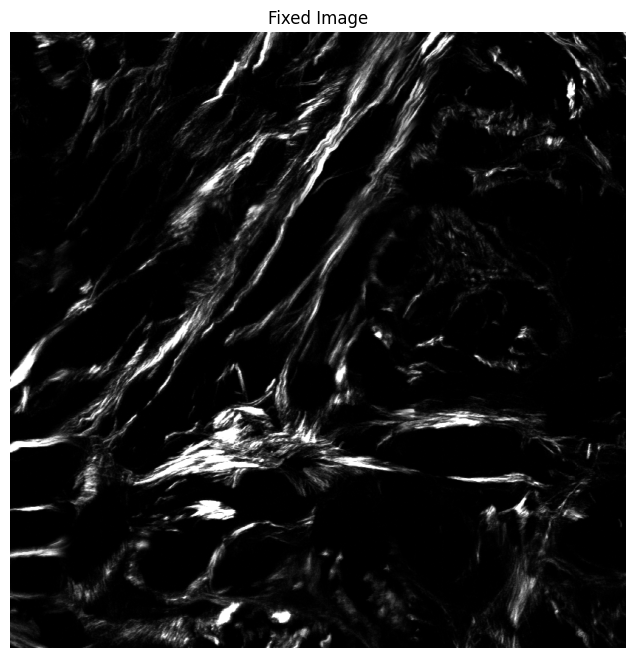

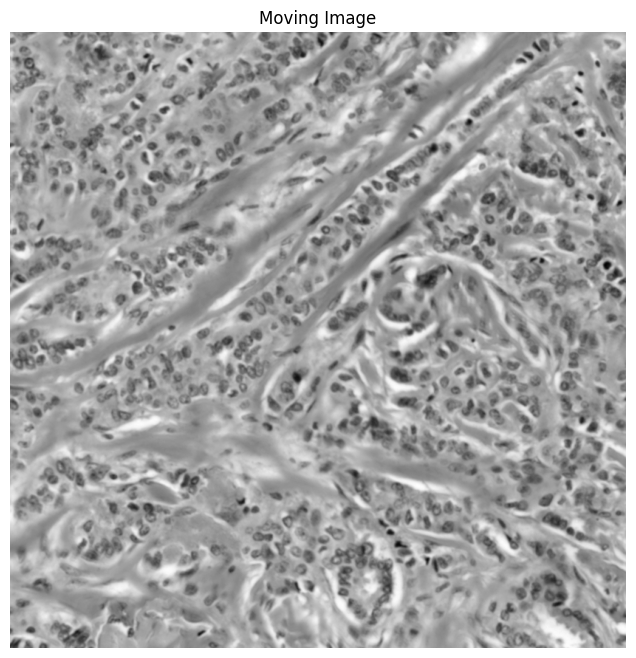

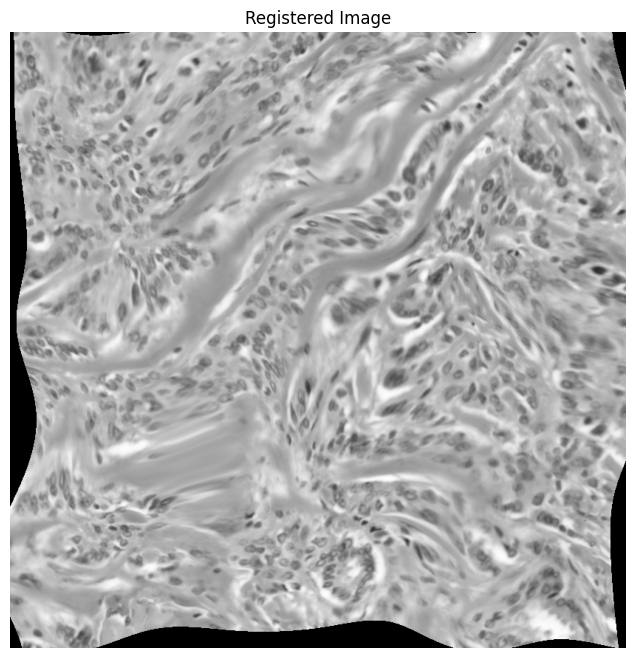

In [82]:
def show_image(image, title="Image"):
    plt.figure(figsize=(10, 8))
    plt.imshow(sitk.GetArrayViewFromImage(image), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


show_image(fixed_image, "Fixed Image")
show_image(moving_image, "Moving Image")
show_image(registered_image, "Registered Image")

(np.float64(-0.5), np.float64(833.5), np.float64(833.5), np.float64(-0.5))

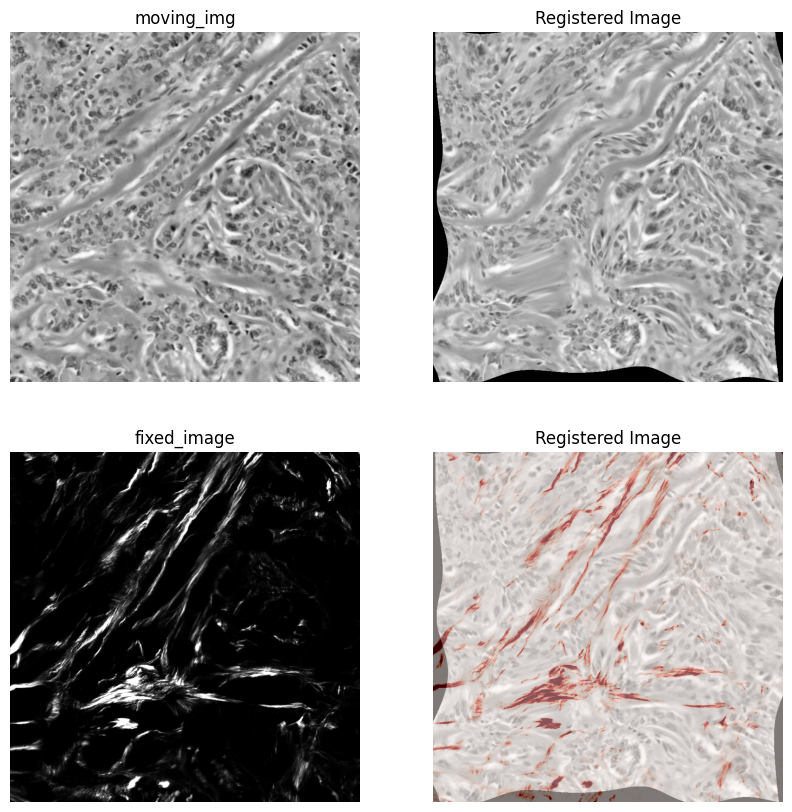

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(sitk.GetArrayViewFromImage(moving_image), cmap='gray')
axs[0,0].set_title("moving_img")
axs[0,0].axis('off')
axs[1,0].imshow(sitk.GetArrayViewFromImage(fixed_image), cmap='gray')
axs[1,0].set_title("fixed_image")
axs[1,0].axis('off')

axs[0,1].imshow(sitk.GetArrayViewFromImage(registered_image), cmap='gray')
axs[0,1].set_title("Registered Image")
axs[0,1].axis('off')
axs[1,1].imshow(sitk.GetArrayViewFromImage(registered_image), cmap='gray')
axs[1,1].set_title("Registered Image")
axs[1,1].axis('off')
axs[1,1].imshow(sitk.GetArrayViewFromImage(fixed_image), cmap='Reds', alpha=0.5)
axs[1,1].set_title("Registered Image")
axs[1,1].axis('off')